## Problem 2 (MPC)
In this problem, we will reuse HW2 Problem 4 and simulate the system, but now with some noise added so that the system must replan at each time step to adapt to unforseen changes.

We set up the problem the same as before. (See HW2 Problem 4 for the details)

Below is the code (more or less) copied from HW2 Problem 4.

In [ ]:

import cvxpy as cp # import cvxpy

# in this problem, we will use the dynamaxsys library to import dynamical systems implemented in JAX: https://github.com/UW-CTRL/dynamaxsys
from dynamaxsys.simplecar import DynamicallyExtendedSimpleCar
from dynamaxsys.base import get_discrete_time_dynamics
from dynamaxsys.utils import linearize


import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import functools
from ipywidgets import interact


In [ ]:
# define the robot dynamics
wheelbase = 1.0
dt = 0.1
ct_robot_dynamics = DynamicallyExtendedSimpleCar(wheelbase=wheelbase) # robot dynamics
dt_robot_dynamics = get_discrete_time_dynamics(ct_robot_dynamics, dt=dt) # discrete time dynamics
state_dim = dt_robot_dynamics.state_dim
control_dim = dt_robot_dynamics.control_dim




In [ ]:
# set up the problem parameters
planning_horizon = 25 # length of the planning horizon
num_time_steps = 50 # number of time steps to simulate
num_sqp_iterations = 15 # number of SQP iterations
t = 0. # this doesn't affect anything, but a value is needed 

# control and velocity limits
v_max = 1.5
v_min = 0.
acceleration_max = 1.0
acceleration_min = -1.0
steering_max = 0.5
steering_min = -0.5

# obstacle parameters
obstacle_location = jnp.array([1.0+t*.1, 0.0+t*.1]) # obstacle location
obstacle_location2 = jnp.array([3.0, -0.5]) # obstacle location
obstacle_radius = 0.5 # obstacle radius
robot_radius = 0.1 # robot radius


In [ ]:
# some helper functions

# define obstacle function g(x) >= 0
# where g(x) is the distance from the obstacle
@jax.jit
def obstacle_constraint(state, obstacle, radius):
    return jnp.linalg.norm(state[:2] - obstacle[:2]) - radius

# function to simulate the discrete time dynamics given initial state and control sequence
@functools.partial(jax.jit, static_argnames=["dt_dynamics"])
def simulate_discrete_time_dynamics(dt_dynamics, state, controls, t0, dt):
    states = [state]
    t = t0
    for c in controls:

        state = dt_dynamics(state, c, t)
        states.append(state)
        t += dt
    return jnp.stack(states)

# function to simulate the discrete time dynamics given initial state and control sequence
# function slightly modified to add noise 
@functools.partial(jax.jit, static_argnames=["dt_dynamics"])
def simulate_discrete_time_dynamics_with_noise(dt_dynamics, state, controls, t0, dt, noises):
    states = [state]
    t = t0
    for (c,noise) in zip(controls, noises):
        state = dt_robot_dynamics(state, c, t) + noise * dt
        states.append(state)
        t += dt
    return jnp.stack(states, -1)

# jit the linearize constraint functions to make it run faster
linearize_obstacle = jax.jit(jax.vmap(jax.grad(obstacle_constraint), in_axes=[0, None, None]))

In [ ]:
# set up cvxpy problem variables and parameters
xs = cp.Variable([planning_horizon+1, state_dim])  # cvx variable for states
us = cp.Variable([planning_horizon, control_dim])  # cvx variable for controls
slack = cp.Variable(1) # slack variable to make sure the problem is feasible
As = [cp.Parameter([state_dim, state_dim]) for _ in range(planning_horizon)]  # parameters for linearized dynamics
Bs = [cp.Parameter([state_dim, control_dim]) for _ in range(planning_horizon)] # parameters for linearized dynamics
Cs = [cp.Parameter([state_dim]) for _ in range(planning_horizon)] # parameters for linearized dynamics

Gs = [cp.Parameter([state_dim]) for _ in range(planning_horizon+1)] # parameters for linearized constraints
hs = [cp.Parameter(1) for _ in range(planning_horizon+1)] # parameters for linearized constraints
Gs2 = [cp.Parameter([state_dim]) for _ in range(planning_horizon+1)] # parameters for linearized constraints
hs2 = [cp.Parameter(1) for _ in range(planning_horizon+1)] # parameters for linearized constraints

xs_previous = cp.Parameter([planning_horizon+1, state_dim]) # parameter for previous solution
us_previous = cp.Parameter([planning_horizon, control_dim]) # parameter for previous solution
initial_state = cp.Parameter([state_dim]) # parameter for current robot state

In [ ]:
# set up cvxpy problem cost and constraints
beta1 = 0.2 # coefficient for control effort
beta2 = 5. # coefficient for progress
beta3 = 10. # coefficient for trust region
slack_penalty = 1000. # coefficient for slack variable
markup = 1.0

objective = beta2 * (xs[-1,2]**2 + xs[-1,1]**2 - xs[-1,0]) + beta3 * (cp.sum_squares(xs - xs_previous) + cp.sum_squares(us - us_previous)) + slack_penalty * slack**2
constraints = [xs[0] == initial_state, slack >= 0] # initial state and slack constraint
for t in range(planning_horizon):
    objective += (beta1 * cp.sum_squares(us[t]) + beta1 * (xs[t,2]**2 + xs[t,1]**2 - xs[t,0]) ) * markup**t
    constraints += [xs[t+1] == As[t] @ xs[t] + Bs[t] @ us[t] + Cs[t]] # dynamics constraint
    constraints += [xs[t,-1] <= v_max, xs[t,-1] >= v_min, us[t,1] <= acceleration_max, us[t,1] >= acceleration_min, us[t,0] <= steering_max, us[t,0] >= steering_min] # control and velocity limit constraints
    constraints += [Gs[t] @ xs[t] + hs[t] >= -slack, Gs2[t] @ xs[t] + hs2[t] >= -slack] # linearized collision avoidance constraint
constraints += [xs[planning_horizon,-1] <= v_max, xs[planning_horizon,-1] >= v_min, Gs[planning_horizon] @ xs[planning_horizon] + hs[planning_horizon] >= -slack, Gs2[planning_horizon] @ xs[planning_horizon] + hs2[planning_horizon] >= -slack] # constraints for last planning horizon step
prob = cp.Problem(cp.Minimize(objective), constraints) # construct problem
  

In [ ]:
# initial states
robot_state = jnp.array([-1.5, -0.5, 0., 1.])  # robot starting state
robot_trajectory = [robot_state] # list to collect robot's state as it replans
sqp_list = [] # list to collect each sqp iteration 
robot_control_list = []  # list to collect robot's constrols as it replans
robot_trajectory_list = [] # list to collect robot's planned trajectories

# initial robot planned state and controls
previous_controls = jnp.zeros([planning_horizon, control_dim]) # initial guess for robot controls
previous_states =  simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, previous_controls, 0., dt) # initial guess for robot states
xs_previous.value = np.array(previous_states) # set xs_previous parameter value
us_previous.value = np.array(previous_controls) # set us_previous parameter value 

### (a) Using open-loop solution
Let's compute the open-loop solution for the first time step. Read the next few cells and answer the question at the end.

(Just run the cell below)

In [ ]:
initial_state.value = np.array(robot_state)
solver = cp.CLARABEL


for i in range(num_sqp_iterations):
    As_value, Bs_value, Cs_value = jax.vmap(linearize, in_axes=[None, 0, 0, None])(dt_robot_dynamics, previous_states[:-1], previous_controls, 0.)
    Gs_value = linearize_obstacle(previous_states, obstacle_location, obstacle_radius + robot_radius) 
    hs_value = jax.vmap(obstacle_constraint, [0, None, None])(previous_states, obstacle_location, obstacle_radius + robot_radius) - jax.vmap(jnp.dot, [0, 0])(Gs_value, previous_states)
    Gs2_value = linearize_obstacle(previous_states, obstacle_location2, obstacle_radius + robot_radius) 
    hs2_value = jax.vmap(obstacle_constraint, [0, None, None])(previous_states, obstacle_location2, obstacle_radius + robot_radius) - jax.vmap(jnp.dot, [0, 0])(Gs2_value, previous_states)

    for i in range(planning_horizon):
        As[i].value = np.array(As_value[i])
        Bs[i].value = np.array(Bs_value[i])
        Cs[i].value = np.array(Cs_value[i])
        Gs[i].value = np.array(Gs_value[i])
        hs[i].value = np.array(hs_value[i:i+1])
        Gs2[i].value = np.array(Gs2_value[i])
        hs2[i].value = np.array(hs2_value[i:i+1])
    Gs[planning_horizon].value = np.array(Gs_value[planning_horizon])
    hs[planning_horizon].value = np.array(hs_value[planning_horizon:planning_horizon+1])
    Gs2[planning_horizon].value = np.array(Gs2_value[planning_horizon])
    hs2[planning_horizon].value = np.array(hs2_value[planning_horizon:planning_horizon+1])
    
    result = prob.solve(solver=solver)
open_controls = us.value
    


Fix a covariance matrix to model the process noise, and precompute the noise

(Just run the cell below)

In [ ]:
key = jax.random.PRNGKey(0)
n_samples = 64
noise_covar = jnp.diag(jnp.array([0.1, 0.1, 0.05, 0.2])) # noise covariance

noises = jax.random.multivariate_normal(key, jnp.zeros(robot_state.shape), noise_covar, shape=(n_samples, open_controls.shape[0]))

Simulate the dynamics with noise, and without noise

(Just run the cell below)

(Note: `jax.vmap` is becoming handy here!)

In [ ]:
noisy_states = jnp.permute_dims(jax.vmap(simulate_discrete_time_dynamics_with_noise, in_axes=[None, None, None, None, None, 0])(dt_robot_dynamics, robot_state, open_controls, 0., dt, noises), (0, 2, 1))
perfect_states = simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, open_controls, 0., dt)

Plot the trajectories

(Just run the cell below)

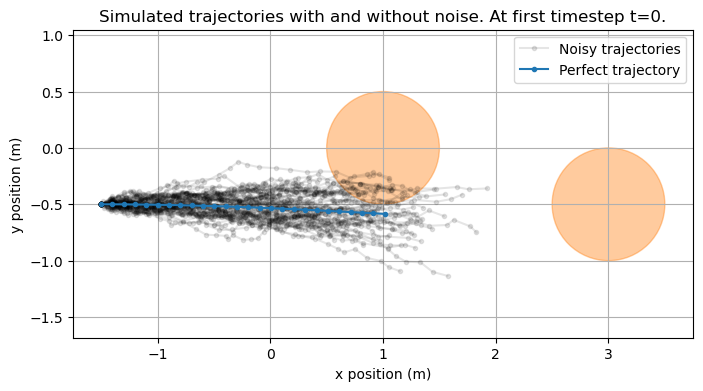

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
robot_position = noisy_states[i, :2]
circle2 = plt.Circle(obstacle_location, obstacle_radius, color='C1', alpha=0.4)
circle3 = plt.Circle(obstacle_location2, obstacle_radius, color='C1', alpha=0.4)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.plot(noisy_states[:,:,0].T, noisy_states[:,:,1].T, "o-", markersize=3, color='black', alpha=0.1)
ax.plot(noisy_states[0,:,0].T, noisy_states[0,:,1].T, "o-", markersize=3, color='black', alpha=0.1, label='Noisy trajectories')
ax.plot(perfect_states[:,0], perfect_states[:,1], "o-", markersize=3, color='C0', label='Perfect trajectory')

ax.set_title("Simulated trajectories with and without noise. At first timestep t=0.")
ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")
ax.set_xlim([-2, 7])
ax.grid()
ax.legend()
ax.axis("equal")
plt.show()


### Comment on what would happen if the robot just executed this open-loop control sequence.

Using only open-loop control, the robot will not have feedback after the initial position. It will not be able to adapt, let alone respond, to the unpredictable noise. This will cause the actual trajectory to diverge from the planned trajectory. We can observe in the above simulation that a high percentage of simulated trajcetories hit an obstacle, which indiciates we need to respond to the noise in some capacity. 

If the robot just executed this open-loop sequence, the robot would most liekly crash, and/or not reach the goal.

### (b) Replan at each timestep!
Hopefully you saw from above the need to replan at each time step.
Run the following cells and answer the question at the end.

(Just run the cell below)


In [ ]:
# initial states
robot_state = jnp.array([-1.5, -0.5, 0., 1.])  # robot starting state
robot_trajectory = [robot_state] # list to collect robot's state as it replans
sqp_list = [] # list to collect each sqp iteration 
robot_control_list = []  # list to collect robot's constrols as it replans
robot_trajectory_list = [] # list to collect robot's planned trajectories

# initial robot planned state and controls
previous_controls = jnp.zeros([planning_horizon, control_dim]) # initial guess for robot controls
previous_states =  simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, previous_controls, 0., dt) # initial guess for robot states
xs_previous.value = np.array(previous_states) # set xs_previous parameter value
us_previous.value = np.array(previous_controls) # set us_previous parameter value 

# precompute the noise
key = jax.random.PRNGKey(0)
noise_covar = jnp.diag(jnp.array([0.1, 0.1, 0.05, 0.2])) # noise covariance
noises = jax.random.multivariate_normal(key, jnp.zeros(robot_state.shape), noise_covar, shape=(num_time_steps,))

Rerun the simulation, replanning at each time step, and adding some noise when computing the robot's next state.

(Just run the cell below)


In [ ]:
solver = cp.CLARABEL

for t in range(num_time_steps):
    initial_state.value = np.array(robot_state)
    sqp_solutions = [previous_states]
    

    
    for i in range(num_sqp_iterations):
        As_value, Bs_value, Cs_value = jax.vmap(linearize, in_axes=[None, 0, 0, None])(dt_robot_dynamics, previous_states[:-1], previous_controls, 0.)
        Gs_value = linearize_obstacle(previous_states, obstacle_location, obstacle_radius + robot_radius) 
        hs_value = jax.vmap(obstacle_constraint, [0, None, None])(previous_states, obstacle_location, obstacle_radius + robot_radius) - jax.vmap(jnp.dot, [0, 0])(Gs_value, previous_states)
        Gs2_value = linearize_obstacle(previous_states, obstacle_location2, obstacle_radius + robot_radius) 
        hs2_value = jax.vmap(obstacle_constraint, [0, None, None])(previous_states, obstacle_location2, obstacle_radius + robot_radius) - jax.vmap(jnp.dot, [0, 0])(Gs2_value, previous_states)

        for i in range(planning_horizon):
            As[i].value = np.array(As_value[i])
            Bs[i].value = np.array(Bs_value[i])
            Cs[i].value = np.array(Cs_value[i])
            Gs[i].value = np.array(Gs_value[i])
            hs[i].value = np.array(hs_value[i:i+1])
            Gs2[i].value = np.array(Gs2_value[i])
            hs2[i].value = np.array(hs2_value[i:i+1])
        Gs[planning_horizon].value = np.array(Gs_value[planning_horizon])
        hs[planning_horizon].value = np.array(hs_value[planning_horizon:planning_horizon+1])
        Gs2[planning_horizon].value = np.array(Gs2_value[planning_horizon])
        hs2[planning_horizon].value = np.array(hs2_value[planning_horizon:planning_horizon+1])
        
        result = prob.solve(solver=solver)

        
        if us.value is None:
            print("No solution found")
            break
        previous_controls = us.value
        previous_states =  simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, previous_controls, 0., dt)
        sqp_solutions.append(previous_states)
        xs_previous.value = np.array(previous_states)
        us_previous.value = np.array(previous_controls)
    sqp_list.append(np.stack(sqp_solutions))
    robot_control = previous_controls[0]
    robot_control_list.append(robot_control)
    
    # get the robot next state using the control input
    robot_state = dt_robot_dynamics(robot_state, robot_control, 0.) + noises[t] * dt
    
    # clipping the robot velocity so the problem doesn't become infeasible at the next step
    robot_state = robot_state.at[3].set(jnp.clip(robot_state[3], v_min, v_max)) 
    
    # add robot state and trajectory to the list
    robot_trajectory.append(robot_state)
    robot_trajectory_list.append(previous_states)
    
    # update the previous states and controls for the next iteration
    previous_states =  simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, previous_controls, 0., dt)
    
    
robot_trajectory = jnp.stack(robot_trajectory)
robot_controls = jnp.stack(robot_control_list)

Visualize the results!

(Just run the cell below)


In [ ]:
# plotting the results. No need to add comments here. Just run this cell to visualize the results
@interact(i=(0,num_time_steps-1), j=(0,num_sqp_iterations-1))
def plot(i, j):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1]})
    # fig, axs = plt.subplots(1,2, figsize=(10, 4))
    ax = axs[0]
    robot_position = robot_trajectory[i, :2]
    print("test",obstacle_location)
    circle1 = plt.Circle(robot_position, robot_radius, color='C0', alpha=0.4)
    circle2 = plt.Circle(obstacle_location, obstacle_radius, color='C1', alpha=0.4)
    circle3 = plt.Circle(obstacle_location2, obstacle_radius, color='C1', alpha=0.4)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.add_patch(circle3)
    ax.plot(robot_trajectory[:,0], robot_trajectory[:,1], "o-", markersize=3, color='black')
    ax.plot(robot_trajectory_list[i][:,0], robot_trajectory_list[i][:,1], "o-", markersize=3, color='red', label="Planned")
    # Plot planned trajectory for the selected SQP iteration
    planned_trajectory = sqp_list[i][j]
    ax.plot(planned_trajectory[:, 0], planned_trajectory[:, 1], "o-", markersize=3, color='green', alpha=0.4, label="SQP iteration %d" % j)
    ax.scatter(robot_trajectory[i:i+1,0], robot_trajectory[i:i+1,1], s=30,  color='C0', label="Robot")
    ax.set_xlim([-2, 7])
    ax.grid()
    ax.legend()
    ax.axis("equal")

    ax.set_title("heading=%.2f velocity=%.2f"%(robot_trajectory[i,2], robot_trajectory[i,3]))
    
    ax = axs[1]
    ax.plot(robot_controls)
    ax.scatter([i], robot_controls[i:i+1, 0], label="$tan(\\delta)$", color='C0')
    ax.scatter([i], robot_controls[i:i+1, 1], label="Acceleration", color='C1')

    ax.hlines(steering_min, 0, num_time_steps-1, color='C0', linestyle='--')
    ax.hlines(steering_max, 0, num_time_steps-1, color='C0', linestyle='--')
    ax.hlines(acceleration_min, 0, num_time_steps-1, color='C1', linestyle='--')
    ax.hlines(acceleration_max, 0, num_time_steps-1, color='C1', linestyle='--')
    
    ax.plot(robot_trajectory[:,-1], markersize=3, color='C2')
    ax.scatter([i], robot_trajectory[i:i+1, 3], label="Velocity", color='C2')
    ax.hlines(v_min, 0, num_time_steps-1, color='C2', linestyle='--')
    ax.hlines(v_max, 0, num_time_steps-1, color='C2', linestyle='--')
    ax.set_xlim([0, num_time_steps])
    ax.set_ylim([-2, 2])
    ax.set_xlabel("Time step")
    ax.set_ylabel("Control")
    ax.set_title("Velocity, steering and acceleration")
    ax.legend()
    ax.grid()

interactive(children=(IntSlider(value=24, description='i', max=49), IntSlider(value=7, description='j', max=14…

Is it guaranteed that your system will not hit the obstacle if we just apply MPC in the way we did above?
If not, what are some techniques you could try to reduce the risk of colliding into the obstacles?

(Optional) What if the obstacles were not stationary. But rather, they were moving. How would the problem change if the obstacle's motion were fully known (e.g., we knew exactly where the obstacle would be at any point in time), or if the obstacle's motion was uncertain (e.g., the obstacles were pedestrians, or space debris whose motion is not fully known). What are some techniques that could be applied to reduce the risk of collision?

It is not guaranteed the system will not hit the obstacle. There are many techniques that can be used to reduce the risk of colliding into obstacles:

- **State restrictions**: Adjust maximum velocity and acceleration to make the robot more capable of reacting quickly to abrupt changes.
- **Increase the frequency of timesteps**: Allows for more opportunities for course correction during replanning.
- **Add a buffer** to the obstacle avoidance constraint: Gives more leeway, especially in the presence of noise.
- **Increase the cost** of getting close to the obstacle: Use a non-linear cost function that scales dramatically upon approach.
- **Increase the planning horizon**.

If the obstacles are moving and their motions are fully known, future positions can be precomputed and used as time-indexed constraints. The obstacle positions will be expressed as a function of time. These can still be handled similarly to stationary obstacles.

If the obstacles are moving and the motions are uncertain, it is necessary to be much more conservative in the face of the unknown. This includes:

- **Shorter planning horizons**: Long-term planning is less useful when short-term conditions can change dramatically and unpredictably.
- **Greater control for obstacle avoidance**: Especially when an obstacle is moving directly toward the robot. Allow the robot to accelerate dramatically to avoid obstacles that appear close by.
- If a **probability distribution** of obstacle positions is known, add a penalty to where the obstacles could be:

  $$
  \text{Penalty} \propto P(\text{obstacle at position } \mathbf{x})
  $$

Additionally, with preparation, reinforcement learning could be used to determine any movement patterns of the obstacles, which could then be incorporated into the open-loop planning.

